In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [3]:
# torch.cuda.current_device()

In [4]:
# torch.cuda.get_device_name(0)

In [5]:
dup_num = 1

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


In [6]:
def load_npy(base_dir='label_data', subpath='mouse 6_28 _ day 20200903', lbl=''):
    
    # dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
    fileName_load = 'stat.npy'

    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    # PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
    print('stat file loaded')
    print('')

    num_ROI = stat.shape[0]
    print(f'Number of ROIs: {num_ROI}')

    height = 512
    width = 1024
    spatial_footprints_centered = np.zeros((num_ROI, 241,241))
    for i in range(num_ROI):
        spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
    spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

    # %matplotlib inline
    plt.figure()
    plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
    plt.title(f'spatial_footprints_centered_crop{lbl} MIP^0.2');

    images = spatial_footprints_centered_crop
    return spatial_footprints_centered_crop

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


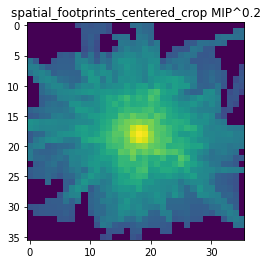

In [7]:
# LOAD stat.npy file 1
#___________________


spatial_footprints_centered_crop = load_npy(base_dir='../../label_data', subpath='mouse 6_28 _ day 20200903')
images = spatial_footprints_centered_crop


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


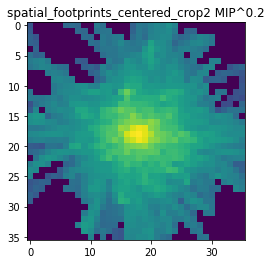

In [8]:
# # LOAD stat.npy file 2
# #___________________


spatial_footprints_centered_crop2 = load_npy(base_dir='../../label_data',
                                             subpath='mouse6_28 _ day20200815',
                                             lbl='2'
                                            )
images2 = spatial_footprints_centered_crop2


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/stat.npy

stat file loaded

Number of ROIs: 4893


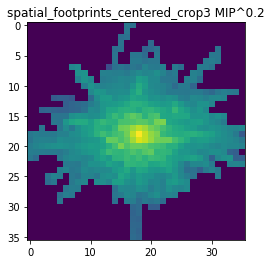

In [9]:
spatial_footprints_centered_crop3 = load_npy(base_dir='../../label_data',
                                             subpath='mouseUnknownAi148__20210325',
                                             lbl='3')
images3 = spatial_footprints_centered_crop3


PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/stat.npy

stat file loaded

Number of ROIs: 4898


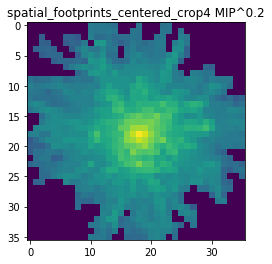

In [10]:
spatial_footprints_centered_crop4 = load_npy(base_dir='../../label_data',
                                             subpath='mouse2_6__20210409',
                                             lbl='4')
images4 = spatial_footprints_centered_crop4


In [11]:
images = np.concatenate((spatial_footprints_centered_crop , spatial_footprints_centered_crop2) , axis = 0)
print(images.shape)

(9715, 36, 36)


In [12]:
def load_labels(base_dir='../../label_data',
                 subpath='mouse 6_28 _ day 20200903',
                 fileName_load='labels_posthoc_filledIn_allCells.npy',
                 num_labels=6):
    
    PATH_absolute = pathlib.Path('.').absolute()
    
    PATH_load_dir_statFile = f'{PATH_absolute}/{base_dir}/{subpath}/'
    
    print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
    print('')

    labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
    print('labels file loaded')
    print('')


    plt.figure()
    # plt.hist(labels,20);
    plt.hist(labels1,20);


    #check in number of labels matches number of images
    if images.shape[0] == len(labels1):
        print('number of labels and images match')
    else:
        print('WARNING: number of labels and images DO NOT match')
    
    return labels1

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded



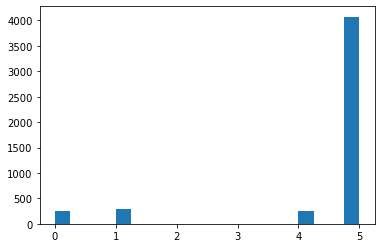

In [13]:
# # LOAD labels file 1
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# fileName_load = 'labels_posthoc_filledIn_allCells.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels1,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels1):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')


labels1 = load_labels(base_dir='../../label_data',
            subpath='mouse 6_28 _ day 20200903',
            fileName_load='labels_posthoc_filledIn_allCells.npy',
            num_labels=6)

In [14]:
images.shape, labels1.shape

((9715, 36, 36), (4868,))

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



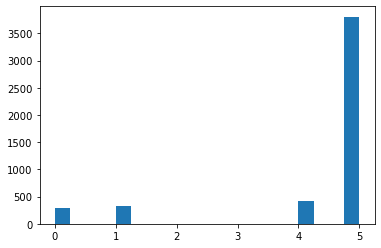

In [15]:
# # LOAD labels file 2
# #___________________

# num_labels = 6

# PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# fileName_load = 'labels_posthoc_all.npy'
# print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
# print('')

# labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
# print('labels file loaded')
# print('')


# plt.figure()
# # plt.hist(labels,20);
# plt.hist(labels2,20);


# #check in number of labels matches number of images
# if images.shape[0] == len(labels2):
#     print('number of labels and images match')
# else:
#     print('WARNING: number of labels and images DO NOT match')
    
    
    
labels2 = load_labels(base_dir='../../label_data',
            subpath='mouse6_28 _ day20200815',
            fileName_load='labels_posthoc_all.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouseUnknownAi148__20210325/labels_posthoc_mouseUnknownAi148__20210325.npy

labels file loaded



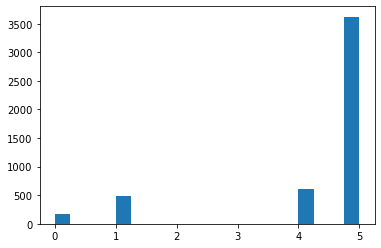

In [16]:
labels3 = load_labels(base_dir='../../label_data',
            subpath='mouseUnknownAi148__20210325',
            fileName_load='labels_posthoc_mouseUnknownAi148__20210325.npy',
            num_labels=6)

PATH:   /Users/josh/Documents/Harvard/GCaMP_ROI_classifier/ROIClassifier-tmp/../../label_data/mouse2_6__20210409/labels_posthoc_mouse2_6__20210409.npy

labels file loaded



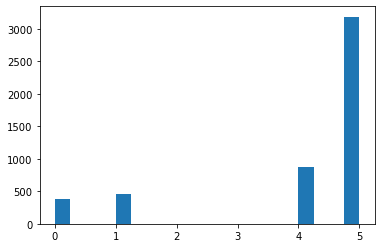

In [17]:
labels4 = load_labels(base_dir='../../label_data',
            subpath='mouse2_6__20210409',
            fileName_load='labels_posthoc_mouse2_6__20210409.npy',
            num_labels=6)

In [18]:
labels = np.concatenate((labels1 , labels2))
print(labels.shape)

(9715,)


In [19]:
np.save('../../trash/temp_images.npy', images)

In [20]:
np.save('../../trash/temp_labels.npy', labels)

In [21]:
seed = 465
np.random.seed(seed)

# create validation set
train_x, val_x, train_y, val_y = train_test_split(images[:], labels[:], test_size = 0.15)

# train_x, train_y = images, labels
tea_x, tea_y = images3, labels3
teb_x, teb_y = images4, labels4
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (tea_x.shape, tea_y.shape), (teb_x.shape, teb_y.shape)

(((8257, 36, 36), (8257,)),
 ((1458, 36, 36), (1458,)),
 ((4893, 36, 36), (4893,)),
 ((4898, 36, 36), (4898,)))

In [22]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

counts = np.histogram(labels,np.arange(7))

weightings_groups_forSampling = np.zeros(6)
for ii in np.array([0,1,4,5]):
    weightings_groups_forSampling[ii] = np.max(counts[0]) / counts[0][ii]

plt.figure()
plt.bar(range(6), weightings_groups_forSampling)

# %matplotlib qt
weightings_forSampling = np.zeros(len(labels)) + 1e-9
for ii in range(len(weightings_forSampling)):
    weightings_forSampling[ii] = weightings_groups_forSampling[labels[ii]]

weightings_forSampling = weightings_forSampling / np.sum(weightings_forSampling)
plt.figure()
plt.plot(weightings_forSampling)
plt.plot(scipy.signal.savgol_filter(weightings_forSampling,11,2))

# light data augmentation
duplicates = 10

# duplication to equalize the probability of encountering each case

images_dup = train_x[0][None,:,:]
labels_aug = np.array([val_y[0]])

for ii in range(6):
    images_dup = np.concatenate( ( images_dup , np.tile(images[labels==ii] ,( np.int16(weightings_groups_forSampling[ii]) , 1 , 1 ) )), axis=0)
    labels_aug = np.concatenate( ( labels_aug , np.ones( np.int16(weightings_groups_forSampling[ii]) * np.sum(labels==ii) ) * ii) )
images_dup = np.tile(images_dup , (duplicates,1,1))
# images_dup = images_dup / np.tile(np.max(images_dup , axis=(1,2)) , (images_dup.shape[1], images_dup.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1
labels_aug = np.tile(labels_aug , duplicates)

test = np.ones(images_dup.shape[0]) * np.nan
images_dup_int8 = np.int8(np.zeros_like(images_dup))
images_dup_uint8 = np.uint8(np.zeros_like(images_dup))
for ii , val in enumerate(images_dup):
    images_dup_int8[ii] = np.int8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) ) -0.5) * 122))
    images_dup_uint8[ii] = np.uint8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) )) * 122))
    test[ii] = np.mean(images_dup_uint8[ii], axis=(0,1))

In [23]:
duplicates = dup_num

images_dup = np.tile(train_x , (duplicates , 1 , 1))
labels_aug = np.tile(train_y , (duplicates))

print(images_dup.shape)
print(labels_aug.shape)

numToGetTo = np.sum(labels_aug==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_aug==ii) <= (np.sum(labels_aug==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_aug==0)/2
    else:
        numToGetTo = np.sum(labels_aug==0)

    idxToDelete = (np.cumsum(labels_aug==ii) * (labels_aug==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_aug = labels_aug[idxToDelete==0]


print(np.sum(labels_aug==0))
print(np.sum(labels_aug==1))
print(np.sum(labels_aug==4))
print(np.sum(labels_aug==5))
print(images_dup.shape)
print(labels_aug.shape)

(8257, 36, 36)
(8257,)
442
442
442
442
221
(1548, 36, 36)
(1548,)


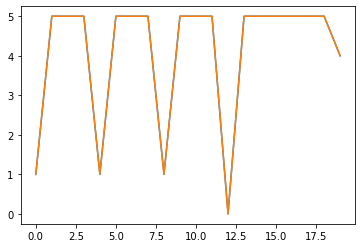

In [24]:
# %matplotlib inline
# %matplotlib inline

plt.figure()
plt.plot(labels_aug[:20])
plt.plot(train_y[:20])
# plt.plot(scipy.signal.savgol_filter(labels_aug , 11 , 3))

# plt.figure()
# plt.imshow(images_dup[5]);
# print(images_dup.dtype)

In [25]:
aug_seq = iaa.Sequential([], random_order=True) # apply augmenters in random order

np.save('images_aug.npy' , images_aug)

images_aug = np.load('images_aug.npy')

(1548, 36, 36)
float64
float64


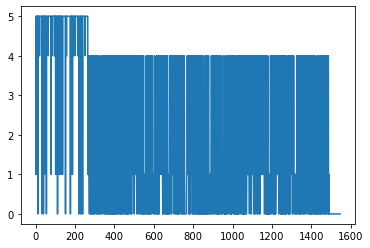

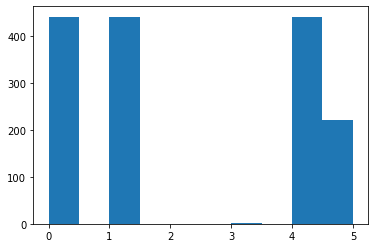

In [26]:
# images_aug = aug_seq(images=images_dup_uint8)
images_aug = aug_seq(images=images_dup)
# images_aug = images_dup
# images_aug = images_aug

# images_aug = images_aug / np.tile(np.max(images_aug , axis=(1,2)) , (images_aug.shape[1], images_aug.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1

print(images_aug.shape)

# plt.figure()
# plt.imshow(images_dup_uint8[6])
plt.figure()
plt.plot(labels_aug)
plt.figure()
plt.hist(labels_aug);

print(images_dup.dtype)
print(images_aug.dtype)

# print(images_aug.shape)
# print(labels_aug.shape)

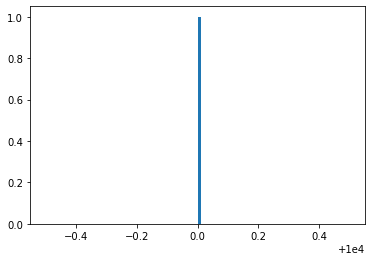

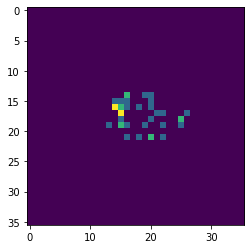

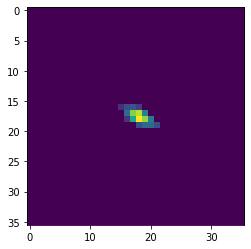

In [49]:
# noiseGain_inverse = np.random.rand(1)**2 * 100 + 10
# plt.figure()
# test = (100 * ( np.random.rand(10000) + 0.1 )**2)+12
# plt.hist(test[test < 1000],100);
# noiseGain_inverse = lambda x: (100 * ( np.random.rand(x) + 0.1 )**2)+50

noiseGain_inverse = lambda x: x
plt.figure()
plt.hist(noiseGain_inverse(10000),100)

images_toUse = images_aug

images_aug_noisy = np.zeros_like(images_toUse)
for ii in range(images_toUse.shape[0]):
    if np.random.rand(1) < 0.8:
        noise = noiseGain_inverse(1)
#         images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) ) * noise / noise * np.max(images_toUse[ii])   # noisy image
        images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) * noise) / noise * np.max(images_toUse[ii])   # noisy image
    else:
        images_aug_noisy[ii] = images_toUse[ii]
plt.figure()
plt.imshow(images_aug_noisy[0])
plt.figure()
plt.imshow(images_aug_noisy[1])

np.save('images_aug.npy' , images_aug)

<IPython.core.display.Javascript object>


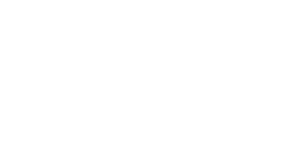

1.216227374970913


In [50]:
%matplotlib notebook
plt.figure()
plt.imshow(images_aug_noisy[8])
print(np.sum(images_aug_noisy[8]))

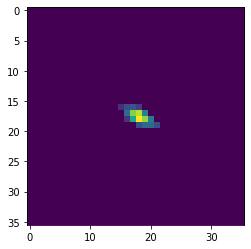

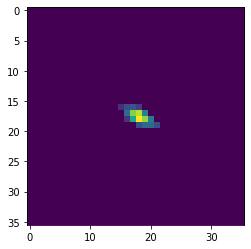

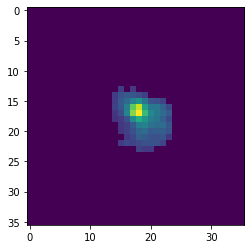

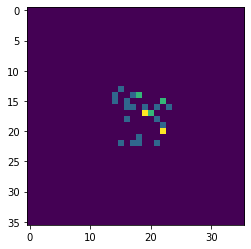

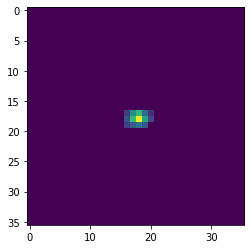

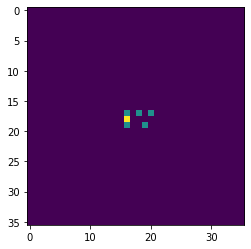

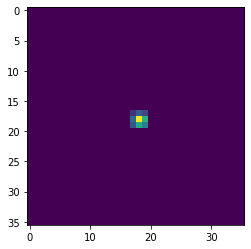

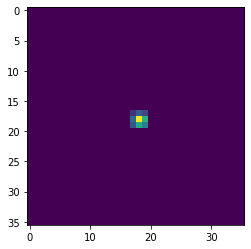

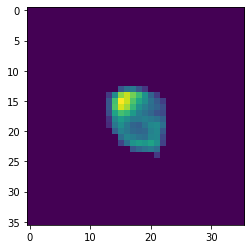

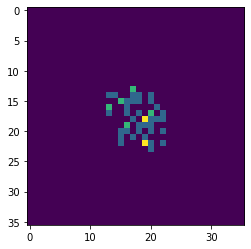

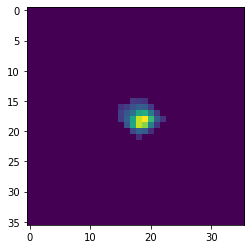

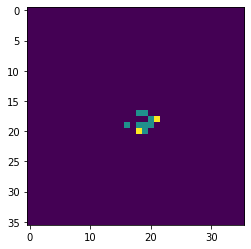

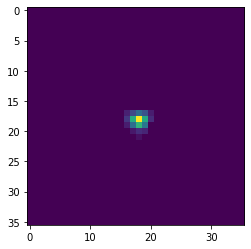

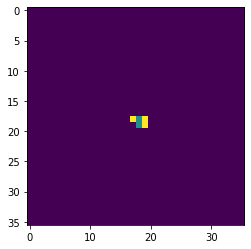

In [51]:
%matplotlib inline
plt.figure()
plt.imshow(images_dup[1])
plt.figure()
plt.imshow(images_aug_noisy[1])
plt.figure()
plt.imshow(images_dup[5])
plt.figure()
plt.imshow(images_aug_noisy[5])
plt.figure()
plt.imshow(images_dup[6])
plt.figure()
plt.imshow(images_aug_noisy[6])
plt.figure()
plt.imshow(images_dup[7])
plt.figure()
plt.imshow(images_aug_noisy[7])
plt.figure()
plt.imshow(images_dup[8])
plt.figure()
plt.imshow(images_aug_noisy[8])
plt.figure()
plt.imshow(images_dup[9])
plt.figure()
plt.imshow(images_aug_noisy[9])
plt.figure()
plt.imshow(images_dup[10])
plt.figure()
plt.imshow(images_aug_noisy[10])

0.3054571542954863
0.0
5
0
(1548, 1, 36, 36)
(1548,)


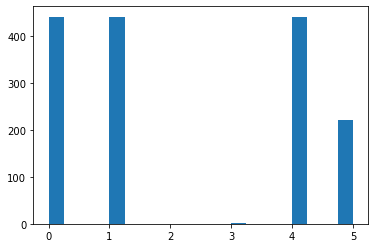

In [52]:
images_toUse = copy.deepcopy(images_aug)

# normalize
for ii in range(images_toUse.shape[0]):
    images_toUse[ii] = images_toUse[ii] / np.sum(images_toUse[ii]) 

# %matplotlib inline
# data_y = copy.deepcopy(labels[:643])
# data_y = np.int16(data_y - 1)

# data_y = train_y
# data_y = copy.deepcopy(labels_posthoc_filledIn)
data_y = copy.deepcopy(labels_aug)
# data_y = labels
# data_y = copy.deepcopy(train_y)

# data_x = images[:643,:,:]
# data_x = images
# data_x = train_x
# data_x = images_aug
# data_x = images_aug_noisy
data_x = images_toUse
# data_x = images_dup
# data_x = data_x / np.max(np.max(data_x, axis=2) , axis=1)[:,None,None]


# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

# train.head()

print(np.max(data_x))
print(np.min(data_x))
print(np.max(data_y))
print(np.min(data_y))
# plt.figure()
# plt.imshow(np.squeeze(data_y[3,:,:,:]))
# data_y
plt.figure()
plt.hist(data_y,20);

# converting training images into torch format
data_x = data_x[:,None,:,:]
# train_x  = torch.from_numpy(train_x)
#data_x = torch.as_tensor(data_x)#.type('torch.cuda.FloatTensor')

# converting the target into torch format
data_y = data_y.astype(int);
# train_y = torch.from_numpy(train_y)
#data_y = torch.as_tensor(data_y)#.type('torch.cuda.LongTensor')

# shape of training data
print(data_x.shape)
print(data_y.shape)

In [53]:
data_x.shape

(1548, 1, 36, 36)

In [54]:
heldOut_x = val_x[: , None , : , :] #torch.as_tensor(val_x[: , None , : , :])#.type('torch.cuda.FloatTensor')
heldOut_y = val_y.astype(int) #torch.as_tensor(val_y.astype(int))#.type('torch.cuda.LongTensor')

hO_tea_x = tea_x[: , None , : , :]
hO_tea_y = tea_y.astype(int)
hO_teb_x = teb_x[: , None , : , :]
hO_teb_y = teb_y.astype(int)
print(heldOut_x.shape)
print(heldOut_y.shape)

(1458, 1, 36, 36)
(1458,)


In [55]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
keras = tf.keras
layers = keras.layers
regularizers = keras.regularizers

# Reorganize "x" Data to Have Channels as Last Dimension
reorg_x = lambda x: np.transpose(x,(0,2,3,1))

In [56]:
# Define LeNet Architecture (with L1 / L2 regularization in place of DropOut)

l1_reg = 1e-5
l2_reg = 1e-4

rich_model_l12 = keras.Sequential([
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(32, 5, (1,1), padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(64, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Flatten(),
    
    layers.Dense(256),
    layers.Activation(keras.activations.relu),
    layers.Dense(6)
    
])

dropout_prob = 0.4

rich_model = keras.Sequential([
    layers.Conv2D(16, 5, (1,1)),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(16, 5, (1,1)),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    
    
    
    
    
    layers.Conv2D(32, 5, (1,1), padding='same'),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    
    
    
    
    
    
    layers.Conv2D(64, 5, (1,1)),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),   
    
    
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(256),
    layers.Activation(keras.activations.relu),
    
    layers.Dropout(dropout_prob*1),
    
    layers.Dense(6)
    
])



In [57]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_conv_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           strides=(2,2),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), strides,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    shrt = layers.Conv2D(filt3, (1,1), strides,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    shrt = layers.BatchNormalization(axis=3)(shrt)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, shrt])

    return prv
    

In [58]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_id_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, inp])

    return prv
    

In [59]:
tf.random.set_seed(seed)

# Create ResNet Architecture

inp = layers.Input(shape=reorg_x(data_x).shape[1:])

prv = inp

# prv = layers.ZeroPadding2D(padding=(3, 3))(prv)
# prv = layers.Conv2D(64, (7, 7),
#                   strides=(2, 2),
#                   padding='valid',
#                   kernel_initializer='he_normal')(prv)
# prv = layers.BatchNormalization(axis=3)(prv)
# prv = layers.Activation('relu')(prv)
# prv = layers.ZeroPadding2D(padding=(1, 1))(prv)
# prv = layers.MaxPooling2D((3, 3), strides=(2, 2))(prv)


prv = make_ResNet_conv_block(prv, 5, [64, 64, 128], strides=(1,1))
prv = make_ResNet_id_block(prv, 5, [64, 64, 128])
prv = make_ResNet_id_block(prv, 5, [64, 64, 128])


# prv = make_ResNet_conv_block(prv, 5, [16, 32, 64], strides=(1,1))
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64],
#                            l1_reg=1e-8,
#                            l2_reg=1e-7)
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64],
#                            l1_reg=1e-8,
#                            l2_reg=1e-7)

# prv = make_ResNet_conv_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])

# prv = make_ResNet_conv_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])

# prv = make_ResNet_conv_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])

prv = layers.Flatten()(prv)
prv = layers.Dense(256)(prv)
prv = layers.Activation(keras.activations.relu)(prv)

# prv = layers.GlobalMaxPooling2D()(prv)

# out = layers.Dense(6, activation='softmax')(prv)
out = layers.Dense(6)(prv)

# out = prv

jz_model = keras.Model(inputs=[inp], outputs=[out])

In [60]:
prv.shape

TensorShape([None, 256])

In [61]:
# Select Model Architecture to Train

# model = rich_model
model = jz_model

In [62]:
# Data Augmentation Generator
# Adapted from: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=30,
    width_shift_range=(-0.05,0.05),
    height_shift_range=(-0.05,0.05),
#     brightness_range=(-0.1, 0.1),
    zoom_range=(0.6, 1.7),
#     preprocessing_function=lambda x: x / np.sum(x) 
)

In [63]:
# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )


# Save Training Curve Data
history = model.fit(datagen.flow(reorg_x(data_x), data_y, batch_size=32),
                    validation_data=(reorg_x(heldOut_x), heldOut_y),
                    callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=20,
                                                            restore_best_weights=True),

                    epochs=200)

res_name = 'resnet_2h'

f'../../models/{res_name}'

Epoch 1/200
49/49 [==============================] - 37s 751ms/step - loss: 1.7535 - accuracy: 0.4289 - val_loss: 3.1511 - val_accuracy: 0.0617
Epoch 2/200
49/49 [==============================] - 37s 753ms/step - loss: 1.3561 - accuracy: 0.5252 - val_loss: 4.2151 - val_accuracy: 0.0617
Epoch 3/200
49/49 [==============================] - 37s 748ms/step - loss: 1.2840 - accuracy: 0.5362 - val_loss: 4.4010 - val_accuracy: 0.0617
Epoch 4/200
49/49 [==============================] - 37s 758ms/step - loss: 1.2695 - accuracy: 0.5581 - val_loss: 4.9339 - val_accuracy: 0.0617
Epoch 5/200
49/49 [==============================] - 37s 747ms/step - loss: 1.2627 - accuracy: 0.5665 - val_loss: 4.7374 - val_accuracy: 0.0617
Epoch 6/200
49/49 [==============================] - 36s 744ms/step - loss: 1.1757 - accuracy: 0.6130 - val_loss: 4.4942 - val_accuracy: 0.0617
Epoch 7/200
49/49 [==============================] - 37s 745ms/step - loss: 1.1628 - accuracy: 0.6150 - val_loss: 3.8149 - val_accuracy:

'../../models/resnet_2g'

In [64]:
model.save(f'../../{res_name}')

INFO:tensorflow:Assets written to: ../../resnet_2g/assets


In [65]:
acc = keras.metrics.Accuracy()
acc.update_state(np.argmax(model.predict(reorg_x(heldOut_x)),-1),heldOut_y)
print('Val Accuracy CV:',acc.result().numpy())

acc_tea = keras.metrics.Accuracy()
acc_tea.update_state(np.argmax(model.predict(reorg_x(hO_tea_x)),-1),hO_tea_y)
print('Val Accuracy Test:',acc_tea.result().numpy())

acc_teb = keras.metrics.Accuracy()
acc_teb.update_state(np.argmax(model.predict(reorg_x(hO_teb_x)),-1),hO_teb_y)
print('Val Accuracy Test:',acc_teb.result().numpy())

Val Accuracy CV: 0.8998628
Val Accuracy Test: 0.8706315
Val Accuracy Test: 0.74213964


In [66]:
from_logits = True

scc = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred = scc(heldOut_y, model.predict(reorg_x(heldOut_x))).numpy()
# sccpred = scc(labels3.astype(int), model.predict(reorg_x(images3[: , None , : , :]))).numpy()
print('Val Loss CV:',sccpred)

scc_tea = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred_tea = scc_tea(hO_tea_y, model.predict(reorg_x(hO_tea_x))).numpy()
print('Val Loss Test:',sccpred_tea)

scc_teb = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
sccpred_teb = scc_teb(hO_teb_y, model.predict(reorg_x(hO_teb_x))).numpy()
print('Val Loss Test:', sccpred_teb)

Val Loss CV: 0.23718002
Val Loss Test: 0.27090794
Val Loss Test: 0.59852964


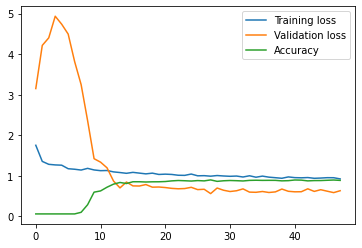

In [67]:
# Generate Training Curves

train_losses = history.history['loss']
val_losses = history.history['val_loss']
accuracy_running = history.history['val_accuracy']

%matplotlib inline
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss') 
plt.plot(accuracy_running, label='Accuracy')
plt.legend()
plt.show()


<ipython-input-68-5e1769de38e0>:23: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


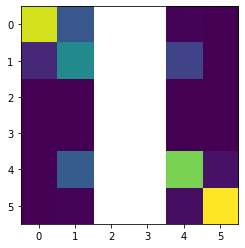

0         1   2   3         4         5
0  0.888889  0.257426 NaN NaN  0.008772  0.000000
1  0.111111  0.455446 NaN NaN  0.192982  0.000867
2  0.000000  0.000000 NaN NaN  0.000000  0.000000
3  0.000000  0.000000 NaN NaN  0.000000  0.000000
4  0.000000  0.277228 NaN NaN  0.763158  0.045967
5  0.000000  0.009901 NaN NaN  0.035088  0.953166

In [68]:
# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(heldOut_x))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(heldOut_y) , 6))
predictions_bool = np.zeros((len(heldOut_y) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (heldOut_y == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

<ipython-input-69-6be9bc5676e6>:25: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


0         1   2   3         4         5
0  0.797619  0.384929 NaN NaN  0.013072  0.000000
1  0.196429  0.433809 NaN NaN  0.148693  0.000552
2  0.000000  0.000000 NaN NaN  0.000000  0.000000
3  0.000000  0.000000 NaN NaN  0.000000  0.000000
4  0.005952  0.162933 NaN NaN  0.745098  0.045003
5  0.000000  0.018330 NaN NaN  0.093137  0.954445

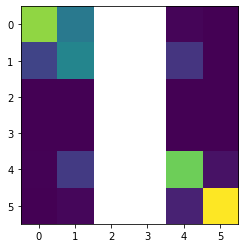

In [69]:
# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(hO_tea_x))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(hO_tea_y) , 6))
predictions_bool = np.zeros((len(hO_tea_y) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (hO_tea_y == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)



from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)

# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()


<ipython-input-70-da6c0b8958e2>:23: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


0         1   2   3         4         5
0  0.399471  0.026374 NaN NaN  0.013621  0.000314
1  0.552910  0.496703 NaN NaN  0.118048  0.001884
2  0.000000  0.000000 NaN NaN  0.000000  0.000000
3  0.000000  0.000000 NaN NaN  0.000000  0.000000
4  0.047619  0.448352 NaN NaN  0.802497  0.196608
5  0.000000  0.028571 NaN NaN  0.065834  0.801193

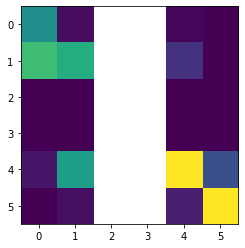

In [70]:
# Generate Confusion Matrix

%matplotlib inline

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(reorg_x(hO_teb_x))

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(hO_teb_y) , 6))
predictions_bool = np.zeros((len(hO_teb_y) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (hO_teb_y == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


# Print Numerical Confusion Matrix
display(pd.DataFrame(matrix_probability))

plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()
